<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/Copy_of_Lecture11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Reading the images

In [70]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
import os
import glob
import numpy as np

import logging
import time

logging.basicConfig(level=logging.INFO)

Fare una read img migliore (?) 
in parallelo se è possibile

In [3]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'
#PATH = 'gdrive/MyDrive/Immagini'

*  Imread restituisce un array 60 x 60

In [4]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    tmp += [ imread(fname) for fname in fnames ]
    labels += len(fnames)*[cls]
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

In [5]:
initial_time = time.time()
path_to_png_data = os.path.join(PATH, 'Train')
x_train, y_train = read_imgs(path_to_png_data, [0, 1])

test_dataset_path =os.path.join(PATH, 'Test')
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

elapsed_time=time.time() - initial_time
logging.info('Done in %.2f seconds',elapsed_time )


INFO:root:Done in 199.45 seconds


(396, 60, 60, 1) (396,)
(401, 60, 60, 1) (401,)


(60, 60)
(60, 60)
(60, 60)
(60, 60)


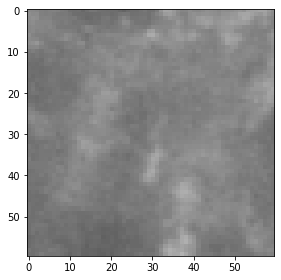

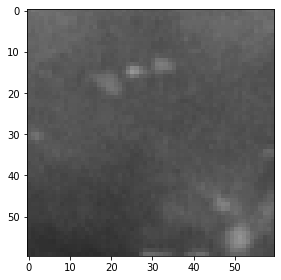

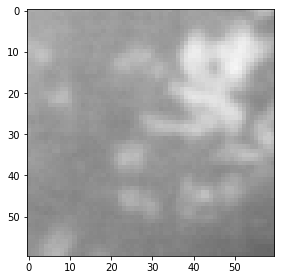

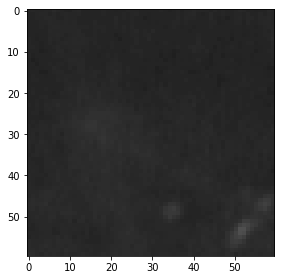

In [99]:
'''
Questa parte serve solo per visualizzare qualche immagine dalla #a alla #a+3
'''

image_type = 'Test/1'
a=6
i=0
plt.figure(i)

for imagename in (os.listdir(os.path.join(PATH, image_type)))[a:a+4]:
  Im = imread(os.path.join(PATH, image_type, imagename))
  print(Im.shape)
 #plt.subplot(2, 2, i)
  plt.figure(i)
  imshow(Im)
  i+=1




# Defining a CNN model

In [8]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [9]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(96, (5,5), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(256, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(384, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(384, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      Conv2D(256, (4,4), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),

      Flatten(), 
      

      Dense(1, activation='sigmoid')
      
  ])
  
  return model



model = make_model()

In [ ]:
'''
def make_model(shape=(60, 60, 1), f1=5, f2=5, f3=5):
  model = Sequential([
      
      Conv2D(f1, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(f2, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),

      Conv2D(f3, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),


      Flatten(), 
      
      #Dense(32, activation = 'relu'),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model
  '''

In [ ]:
model.summary()

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5,
    patience = 5,
    min_lr=0.00001

)

checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')


In [ ]:

model = make_model()
#model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr = 0.001, momentum = 0.9), metrics = 'accuracy', loss='binary_crossentropy')


history = model.fit(x_train, y_train, 
                    validation_split=0.3, 
                    epochs=300, 
                    batch_size=30, 
                    shuffle=True, 
                    callbacks = [checkpoint],
                    verbose=1)



print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [14]:
model.save(os.path.join(PATH, 'model.hdf5'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 96)        2496      
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 60, 96)        384       
_________________________________________________________________
activation_5 (Activation)    (None, 60, 60, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       221440    
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 256)      

# Data augmentation
 Before we can run data aumentation with ImageDataGenerator we need to convert the PGM format to PNG

In [ ]:
basename = os.path.basename(PATH)
print(basename)

Mammography_micro


In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


Provare a fare una funzione migliore per convertire tutti i pgm in png

In [ ]:
start_time = time.time()
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)
print(time.time()-start_time)

291.19284987449646


# Data aumentation

In [16]:
import matplotlib.pyplot as plt

In [17]:
from keras.preprocessing.image import ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Il FLOW_FROM_DIRECTORY prende in input il path della directory di arrivo e genera gruppi di immagini dando in output un ITERATORE (x, y) con y le labels e x le immagini con shape (batch_size, *target_size, channels)

di defoult crea le img in png

*  batch_size (di default è 32) cioè il numero di immagini modificate generate per ogni immagine di X_train.

*  subset = training o validation, funziona solo se c'è validation_split nel 




ImageDataGenerator


IMAGEDATAGENERATOR:
Validation_split = 0.3 divide tutte le N immagini di x_train in: 70% train e 30% validazione e usa questo dataset nel model.fit 



In [30]:
path_to_png_data = os.path.join(PATH, "Train_png")

img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2, #shear deforma l'immagine "tirandola tra due lati"
        zoom_range=0.2, 
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.3)  
        



train_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    path_to_png_data,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')



Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


Il.next() accede ad una immagine. train_gen.next()[0] ha shape = (32, 60, 60, 1) cioè per ogni immagine del dataset, lui genera 32 immagini modificate di dimensione 60x60 di colori grayscale

In [32]:
'''
img = train_gen.next()[0][0].squeeze()
print(img.shape)
plt.imshow(img) #facendo cosi ne mostra una diversa ogni volta 
print(train_gen.next()[1][0]) #mostra la label corrispondente (?)
'''
print(len(train_gen))
print(len(train_gen[0][0][0][0][0]))

print(train_gen)
#print(len(train_gen.next()[1]))
#plt.imshow(train_gen)

#train_gen.next()[0].shape 

9
1


(32,)

# Testing model on new images

In [33]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [34]:
model = make_model()
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

STEPS_PER_EPOCH: Definisce il numero di immagini da usare ad ogni epoca, è utile quando il numero delle immagini non è fisso perchè vengono generate potenzialmente infiniti samples

In [36]:
batch_size=32
#steps_per_epoch = 
history = model.fit(
        train_gen,
        steps_per_epoch=278 // batch_size,
        epochs=50,
        validation_data=val_gen,
        validation_steps= 118 // batch_size,
        verbose=0,
        callbacks=[checkpoint])


Epoch 00001: val_accuracy improved from -inf to 0.47917, saving model to model_augmented.01-0.48.h5

Epoch 00002: val_accuracy did not improve from 0.47917

Epoch 00003: val_accuracy improved from 0.47917 to 0.50000, saving model to model_augmented.03-0.50.h5

Epoch 00004: val_accuracy did not improve from 0.50000

Epoch 00005: val_accuracy improved from 0.50000 to 0.78125, saving model to model_augmented.05-0.78.h5

Epoch 00006: val_accuracy did not improve from 0.78125

Epoch 00007: val_accuracy did not improve from 0.78125

Epoch 00008: val_accuracy did not improve from 0.78125

Epoch 00009: val_accuracy did not improve from 0.78125

Epoch 00010: val_accuracy did not improve from 0.78125

Epoch 00011: val_accuracy did not improve from 0.78125

Epoch 00012: val_accuracy did not improve from 0.78125

Epoch 00013: val_accuracy did not improve from 0.78125

Epoch 00014: val_accuracy did not improve from 0.78125

Epoch 00015: val_accuracy did not improve from 0.78125

Epoch 00016: val_a

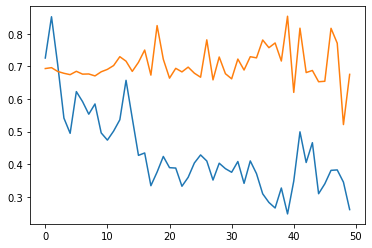

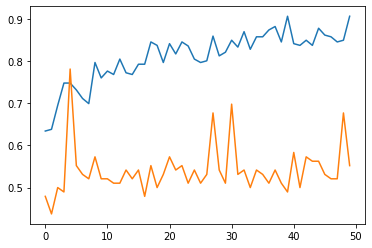

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Saving the model

In [38]:
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

# Evaluate the performances of the two models

In [39]:
from keras.models import load_model
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))

In [40]:
x_test, y_test = read_imgs(os.path.join(PATH, "Test"), [0,1])

In [41]:
noaug_model.evaluate(x_test, y_test)

aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 15ms/step - loss: 0.6845 - accuracy: 0.5686


[0.684547483921051, 0.5685785412788391]

# Visualizing

In [ ]:
#plt.imshow()

In [42]:
model= load_model(os.path.join(PATH, 'model_augmented.hdf5'))

In [43]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]
print(model.input)
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 60, 60, 1), dtype=tf.float32, name='conv2d_15_input'), name='conv2d_15_input', description="created by layer 'conv2d_15_input'")


In [44]:
print(model.input.shape)
print(len(model.layers))
model.layers

(None, 60, 60, 1)
20


micro_calc shape =  (1, 60, 60, 1)


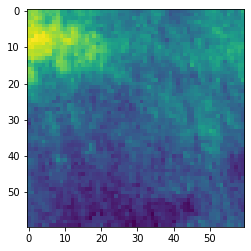

In [45]:
micro_calc = val_gen.next()[0][2][np.newaxis,...]
print('micro_calc shape = ', micro_calc.shape)
#print(micro_calc.squeeze())
plt.imshow(micro_calc.squeeze())

In [46]:
activations = activation_model.predict(micro_calc)

In [47]:
len(activations) == len(model.layers)

True

In [48]:
activations[0].shape
print(activations[0].shape)
print(activations[14].shape)

(1, 60, 60, 96)
(1, 15, 15, 256)


ValueError: ignored

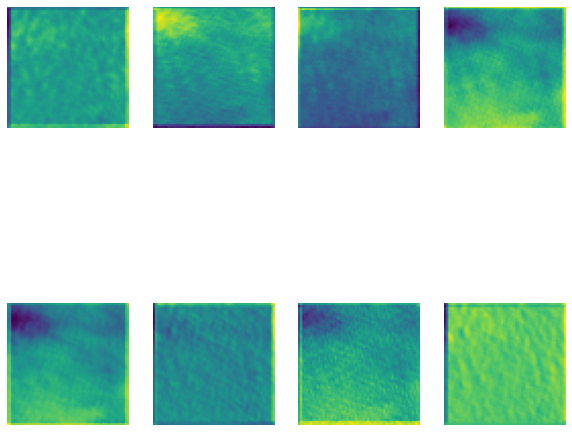

In [49]:
fig = plt.figure(figsize=(10,10))
n_range = activations[0].shape[3]
for k in range(n_range):
  plt.subplot(2,4, k+1)
  plt.imshow(activations[0][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.5, wspace=0.2)
fig.tight_layout(pad=1)

In [ ]:
fig = plt.figure(figsize=(15,15))

for k in range(n_range):
  plt.subplot(2,8, k+1)
  plt.imshow(activations[5][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

In [ ]:
fig = plt.figure(figsize=(15,15))
for k in range(n_range-1):
  plt.subplot(4,8, k+1)
  plt.imshow(activations[8][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

## Visualizing filters

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()

In [ ]:
for k in range(8):
  plt.subplot(2, 4, k+1)
  plt.imshow(filters[:,:,k], cmap='gray')
  plt.axis(False)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[4].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()
for k in range(16):
  plt.subplot(2, 8, k+1)
  plt.imshow(filters[:,:,1 ,k], cmap='gray')
  plt.axis(False)

In [ ]:
filters.shape